In [1]:
import bnlp
import gensim
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve

from sklearn.metrics import accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D



C:\Users\Sudhakor Das\anaconda3\envs\tensor\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
from bnlp.corpus import stopwords, punctuations, letters, digits
from bnlp.corpus.util import remove_stopwords
#print(stopwords)
#print(punctuations)
#print(letters)
#print(digits)
#ext = 'আমি বাংলাদেশকে অনেক ভালোবাসি !#$%&()*+,-./:;<=>?@[\]^_`{|}~।ঃ '

In [3]:
#Reading the dataset

df = pd.read_excel('local.xlsx', engine='openpyxl')
df.head()

,Bangla,Label
0,"খানকির* !#$%&()*+,-./:;<=>?@[\]^_`{|}~।ঃ পোয়া...",Yes
1,আঁরার উরুস্তুল ভালা দেশসেরা জোয়ান এমপির ব্য...,No
2,খানকির পোয়া রোহিঙ্গাওক্কলড়ে দেষত্তূণ বাইড় গো...,Yes
3,"মাশরাফি ভাইয়ুর নান মানুষ নয়, বাচি থাকাক আজার ম...",No
4,কালাইয়া আলারপোয়ালা খাঙ্কির পোয়া অইলদি আস্তা মা...,Yes


In [4]:
df.shape

(1099, 2)

In [5]:

# counting the label in each category
df["Label"].value_counts()


Yes    571
No     528
Name: Label, dtype: int64

In [6]:
#Encoding the Label 
#comment_label = df.Label.factorize()
#comment_label[0]

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])


In [7]:
list(le.classes_)

['No', 'Yes']

In [8]:
list(le.inverse_transform([1,0]))

['Yes', 'No']

In [9]:
df['Label'][0]

1

In [10]:
'''punc = '!#$%&()*+,-./:;<=>?@[\]^_`{|}~।ঃ'
a = []
def remove_punctuations(text):
    for ele in text:
        a.append(ele)
        print(ele)
        if ele in punc:
            text = text.replace(ele, '')

    return text , a 
    
text = 'i. love.// my>, my Country'

#remove_punctuations(text)
print(remove_punctuations(text))
'''

"punc = '!#$%&()*+,-./:;<=>?@[\\]^_`{|}~।ঃ'\na = []\ndef remove_punctuations(text):\n    for ele in text:\n        a.append(ele)\n        print(ele)\n        if ele in punc:\n            text = text.replace(ele, '')\n\n    return text , a \n    \ntext = 'i. love.// my>, my Country'\n\n#remove_punctuations(text)\nprint(remove_punctuations(text))\n"

# Functions definitions for cleaning comments

In [11]:
###########                    Removing Punctuations                  ##############
punc = '!#$%&()*+,-./:;<=>?@[\]^_`{|}~।ঃ'
  
def remove_punctuations(text):
    for ele in text:
        if ele in punc:
            text = text.replace(ele, '')

    return text   

###########                    Removing emojis                  ##############

def remove_emojis(text):
    """
    Result :- string without any emojis in it
    Input :- String
    Output :- String
    """
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)

    without_emoji = emoji_pattern.sub(r'',text)
    return without_emoji


'''def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
'''
###########                    digits                ##############
def remove_numbers(text):
    """
    Return :- String without numbers
    input :- String
    Output :- String
    """
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl="", string=text)
    
    return without_number


In [12]:
text = []
def text_preprocessing(sentences):
    for sen in sentences:
        sent = remove_punctuations(sen)
        sent = re.sub('[a-zA-Z]', '', sent)
        sent = remove_emojis(sent)
        sent = remove_numbers(sent)
        
        text.append(sent)
    return text


In [13]:
#df['Clean_text'] = text_preprocessing(df['Bangla'])

In [14]:
df.head()

,Bangla,Label
0,"খানকির* !#$%&()*+,-./:;<=>?@[\]^_`{|}~।ঃ পোয়া...",1
1,আঁরার উরুস্তুল ভালা দেশসেরা জোয়ান এমপির ব্য...,0
2,খানকির পোয়া রোহিঙ্গাওক্কলড়ে দেষত্তূণ বাইড় গো...,1
3,"মাশরাফি ভাইয়ুর নান মানুষ নয়, বাচি থাকাক আজার ম...",0
4,কালাইয়া আলারপোয়ালা খাঙ্কির পোয়া অইলদি আস্তা মা...,1


In [15]:
from wordcloud import WordCloud
regex = r"[\u0980-\u09FF]+"


plt.figure()
wc= WordCloud(max_words=20,regexp=regex).generate(" ".join(df[df['Label']==1]['Clean_text']))
plt.title('WordCloud of non abusive sentence')
plt.imshow(wc, interpolation='bilinear')

KeyError: 'Clean_text'

<Figure size 432x288 with 0 Axes>

In [16]:
clean_text = text_preprocessing(df['Bangla'])
len(clean_text)

1099

# Removing Stopwords

In [17]:
stop_words = {'কি','তুই','ইতি', 'তুঁই', 'তোর','তোরে','অই', 'তো', 'নো', 'অনর', 'আই' ,'তোয়ারে','বেজ্ঞুনে','আর', 'আঁর', 'নাটক','ওজ্ঞা','ত', 'আঁই', 'ইঁতি', 'ইঁতারে', 'যেই', 
             'ঈতি', 'ঈতারে', 'লই', 'না', 'অইলি', 'দি', 'তইলি', 'তি', 'হন', 'বিয়া', 'যাই', 'হথা','অয়', 'ওরে', 'চাই','কেওর','যদি',
             'মনয়', 'মনত','বেশি', 'নাকি', 'তরারে', 'যেঁত্তে', 'এত্তে', 'হইলেই', 'গেলি', 'ইয়ান', 'নও', 'অইতু', 'কইউম', 'কিছু', 'হইলি',
             'দন', 'চাইতে', 'তুন', 'দে', 'এই', 'ভরি', 'যেন', 'দে', 'অনে', 'কারে', 'লই', 'অইবু', 'মাজখানে', 'দিয়ে', 'গরি', 'নিজর',
             'হইবুয়', 'আগে', 'কাছে', 'আইস', 'তোয়ারে', 'তুনো', 'আছে', 'দিয়ে', 'যা', 'বলে', 'লাগের', 'নাই', 'কেন', 'চাছুনা', 'বলে', 'আইজু',
             'হদ্দে', 'নান', 'আইয়ি', 'মত', 'লাইবু', 'অইল', 'লই', 'সব', 'গরি', 'দিবু', 'কাছেই', 'হর', 'নেকি', 'কস', 'হই', 'মনে','গরে', 'উধু',
             'জাইবু', 'হয়', 'অইলিদি', 'অলর', 'যআইত', 'পারে', 'তুরা', 'নে', 'এত', 'ইতিরে' 'হনে', 'ওদা', 'পরে', 'রহম', 'লাগে', 'ইয়ন',
             'চাইতাম', 'তা', 'যা', 'লগে', 'তে','কেও', 'ন', 'পার', 'ইবা', 'চাই','এবং', 'হনো', 'যাই', 'ওই', 'এন', 'চাই', 'সেই', 'হতা' }
remove_stop_text = []
def filter_stop_words(sentences, stop_words):
    for i, sentence in enumerate(sentences):
        new_sent = [word for word in sentence.split() if word not in stop_words]
        #clean_text[i] = ' '.join(new_sent)
        remove_stop_text.append(new_sent)
    return remove_stop_text


In [18]:
final_text= filter_stop_words(clean_text, stop_words)
#final_text= filter_stop_words(tweet_df['Bangla'], stop_words)

In [19]:
len(final_text)

1099

In [20]:
final_text[0]

['খানকির', 'পোয়া', 'রোহিঙ্গা', 'অল', 'বাংলাদেশেত', 'ঢুকিলী']

In [21]:
from gensim.models import  FastText
fst_model = FastText(final_text,
                              min_count = 1,
                               window=5,
                                   epochs = 20 
                             )

In [22]:
fst_model.wv.key_to_index

{'মাগি': 0,
 'মাগির': 1,
 'পোস্ট': 2,
 'দুধ': 3,
 'পোয়া': 4,
 'ভালা': 5,
 'হানকি': 6,
 'বালর': 7,
 'বদ্দা': 8,
 'সুন্দর': 9,
 'বড়': 10,
 'চাটগাঁইয়া': 11,
 'ইবে': 12,
 'লায়': 13,
 'গরন': 14,
 'ফালতু': 15,
 'আঁরার': 16,
 'পোন': 17,
 'ইয়েন': 18,
 'ইতার': 19,
 'হাম': 20,
 'বউত': 21,
 'ভাষা': 22,
 'পানি': 23,
 'গ্রুপ': 24,
 'কা': 25,
 'অল': 26,
 'মাগিরে': 27,
 'ফিডে': 28,
 'এগিন': 29,
 'ভাই': 30,
 'আছিল': 31,
 'এপ্রুভ': 32,
 'কিন্তু': 33,
 'দরহার': 34,
 'ঠিক': 35,
 'সানাই': 36,
 'নু': 37,
 'যে': 38,
 'ও': 39,
 'আঁরা': 40,
 'চিটাইঙ্গে': 41,
 'হানকির': 42,
 'মানুষ': 43,
 'এক্কান': 44,
 'জিনিস': 45,
 'লেহা': 46,
 'গ্রুপুত': 47,
 'মারি': 48,
 'গ্রুপুর': 49,
 'মতো': 50,
 'এহন': 51,
 'আলার': 52,
 'দিয়ুম': 53,
 'বাইর': 54,
 'নতুন': 55,
 'মাইয়া': 56,
 'আরো': 57,
 'ইতারে': 58,
 'লাই': 59,
 'মাইয়াপোয়া': 60,
 'পরিবু': 61,
 'আফা': 62,
 'গরম': 63,
 'গেইয়ি': 64,
 'নাম': 65,
 'এক': 66,
 'বত': 67,
 'মজা': 68,
 'মিনিটে': 69,
 'চোদা': 70,
 'হত্তুন': 71,
 'পুরাই': 72,
 'হষ্ট': 73,
 'হেডার': 74,
 'আবার': 75,
 

In [23]:
fst_model.wv.most_similar('হাঙ্কি')

[('হাঙ্কিরে', 0.9999855756759644),
 ('হারন', 0.9999809265136719),
 ('হারাই', 0.9999803304672241),
 ('হাম', 0.9999797940254211),
 ('হারাইয়ু', 0.9999794960021973),
 ('হাচারা', 0.9999789595603943),
 ('হারনে', 0.9999788999557495),
 ('হারি', 0.99997878074646),
 ('হারাম', 0.9999784231185913),
 ('হারাফ', 0.9999776482582092)]

In [24]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(final_text)

In [25]:
final_text[0]

['খানকির', 'পোয়া', 'রোহিঙ্গা', 'অল', 'বাংলাদেশেত', 'ঢুকিলী']

In [26]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

4639

In [27]:
W2V_SIZE = 100
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in fst_model.wv:
    embedding_matrix[i] = fst_model.wv[word]
print(embedding_matrix.shape)

(4639, 100)


In [28]:
print(tokenizer.word_index)

{'মাগি': 1, 'মাগির': 2, 'পোস্ট': 3, 'দুধ': 4, 'পোয়া': 5, 'ভালা': 6, 'হানকি': 7, 'বালর': 8, 'বদ্দা': 9, 'বড়': 10, 'সুন্দর': 11, 'চাটগাঁইয়া': 12, 'ইবে': 13, 'লায়': 14, 'আঁরার': 15, 'গরন': 16, 'ফালতু': 17, 'পোন': 18, 'ইয়েন': 19, 'ইতার': 20, 'হাম': 21, 'ভাষা': 22, 'বউত': 23, 'অল': 24, 'কা': 25, 'গ্রুপ': 26, 'পানি': 27, 'আছিল': 28, 'ভাই': 29, 'মাগিরে': 30, 'এগিন': 31, 'ফিডে': 32, 'এপ্রুভ': 33, 'কিন্তু': 34, 'ঠিক': 35, 'সানাই': 36, 'নু': 37, 'দরহার': 38, 'ও': 39, 'যে': 40, 'চিটাইঙ্গে': 41, 'আঁরা': 42, 'হানকির': 43, 'মানুষ': 44, 'এক্কান': 45, 'জিনিস': 46, 'মারি': 47, 'গ্রুপুর': 48, 'লেহা': 49, 'গ্রুপুত': 50, 'এহন': 51, 'বাইর': 52, 'নতুন': 53, 'দিয়ুম': 54, 'মাইয়া': 55, 'আলার': 56, 'মতো': 57, 'পরিবু': 58, 'মাইয়াপোয়া': 59, 'ইতারে': 60, 'আরো': 61, 'লাই': 62, 'নাম': 63, 'এক': 64, 'গরম': 65, 'আফা': 66, 'গেইয়ি': 67, 'মজা': 68, 'হত্তুন': 69, 'মিনিটে': 70, 'চোদা': 71, 'বত': 72, 'অইলদি': 73, 'হারাপ': 74, 'কুত্তার': 75, 'এড': 76, 'আবার': 77, 'হেডার': 78, 'চুদি': 79, 'পুরাই': 80, 'গইজ্জুন': 81, 'অইয়ি': 8

In [29]:
encoded_docs = tokenizer.texts_to_sequences(final_text)

In [30]:

encoded_docs[7]

[102, 1554, 1555, 1556, 1557]

In [31]:
padded_sequence = pad_sequences(encoded_docs, maxlen=20)

In [32]:
print(final_text[0])
print(encoded_docs[0])
print(padded_sequence[0])

['খানকির', 'পোয়া', 'রোহিঙ্গা', 'অল', 'বাংলাদেশেত', 'ঢুকিলী']
[303, 5, 832, 24, 1522, 1523]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
  303    5  832   24 1522 1523]


In [33]:
X = np.array(padded_sequence)
y = df['Label']
#y = comment_label[0]

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

NameError: name 'X' is not defined

# Function definition for Testing the model

In [35]:
Model = list()
Accuracy = list()
precision = list()
recall = list()
F1score = list()


In [36]:
def test_eval(clf_model, X_test, y_test, algo=None):
    # Test set prediction
    y_prob=clf_model.predict_proba(X_test)
    y_pred=clf_model.predict(X_test,verbose=1)
    #y_pred=clf_model.predict(X_test)

    print('Confusion Matrix')
    print('='*60)
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    print('Accuracy Score')
    print('='*60)
    print(accuracy_score(y_test, y_pred))
          
    Model.append(algo)
    Accuracy.append(round(accuracy_score(y_test, y_pred),2))
    precision.append(round(precision_score(y_test,y_pred),2))
    recall.append(round(recall_score(y_test,y_pred),2))
    F1score.append(round(f1_score(y_test,y_pred),2))
   
    

# Fast-text + Simple RNN

In [64]:
maxlen = 20
#embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)
simrnn_model = Sequential()

simrnn_model.add(Embedding(vocab_size ,W2V_SIZE ,weights=[embedding_matrix], input_length = maxlen, name = "embedding", trainable = True))
simrnn_model.add(SimpleRNN(100, activation = 'relu', return_sequences = True))
simrnn_model.add(SimpleRNN(160, activation = 'relu'))
#simrnn_model.add(SimpleRNN(200, activation = 'relu', return_sequences = True))
#simrnn_model.add(SimpleRNN(256, activation = 'relu'))
simrnn_model.add(Dense(1, activation = 'sigmoid'))
simrnn_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
simrnn_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           463900    
_________________________________________________________________
simple_rnn_30 (SimpleRNN)    (None, 20, 100)           20100     
_________________________________________________________________
simple_rnn_31 (SimpleRNN)    (None, 160)               41760     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 161       
Total params: 525,921
Trainable params: 525,921
Non-trainable params: 0
_________________________________________________________________


In [65]:
simrnn = simrnn_model.fit(X_train,y_train,validation_split=0.2, epochs=40)

Epoch 1/40
19/19 [==============================] - 5s 77ms/step - loss: 0.6957 - accuracy: 0.5345 - val_loss: 0.6584 - val_accuracy: 0.5878
Epoch 2/40
19/19 [==============================] - 1s 41ms/step - loss: 0.6431 - accuracy: 0.6075 - val_loss: 0.6780 - val_accuracy: 0.5405
Epoch 3/40
19/19 [==============================] - 1s 41ms/step - loss: 0.6063 - accuracy: 0.6726 - val_loss: 0.6154 - val_accuracy: 0.6554
Epoch 4/40
19/19 [==============================] - 1s 41ms/step - loss: 0.4572 - accuracy: 0.7999 - val_loss: 0.5775 - val_accuracy: 0.7568
Epoch 5/40
19/19 [==============================] - 1s 43ms/step - loss: 0.1827 - accuracy: 0.9590 - val_loss: 0.3411 - val_accuracy: 0.8716
Epoch 6/40
19/19 [==============================] - 2s 87ms/step - loss: 0.0468 - accuracy: 0.9920 - val_loss: 0.2901 - val_accuracy: 0.9324
Epoch 7/40
19/19 [==============================] - 2s 87ms/step - loss: 0.0092 - accuracy: 0.9998 - val_loss: 2.8031 - val_accuracy: 0.6081
Epoch 8/40
19

In [36]:
'''scores = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
score = model.predict(X_test)
y_p = np.where(score>.5,1,0)
y_p'''

"scores = model.evaluate(X_test, y_test, verbose=0)\nprint('Test loss:', scores[0])\nprint('Test accuracy:', scores[1])\nscore = model.predict(X_test)\ny_p = np.where(score>.5,1,0)\ny_p"

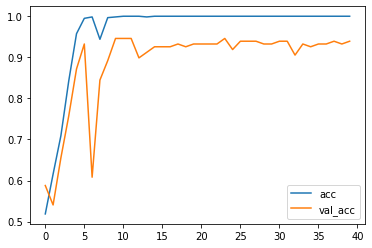

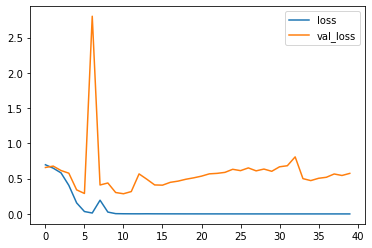

<Figure size 432x288 with 0 Axes>

In [66]:
plt.plot(simrnn.history['accuracy'], label='acc')
plt.plot(simrnn.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")


# In[25]:


plt.plot(simrnn.history['loss'], label='loss')
plt.plot(simrnn.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

In [67]:
test_eval(simrnn_model, X_test, y_test, algo='SimpleRNN')

C:\Users\Sudhakor Das\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


12/12 [==============================] - 1s 9ms/step
Confusion Matrix
[[165  10]
 [ 25 163]] 

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       175
           1       0.94      0.87      0.90       188

    accuracy                           0.90       363
   macro avg       0.91      0.90      0.90       363
weighted avg       0.91      0.90      0.90       363
 

Accuracy Score
0.9035812672176309


In [68]:
Accuracy

[0.9]

In [221]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    print(tw)
    tw = pad_sequences(tw,maxlen=15)
    print(tw)

    pred = model.predict(tw)
    print(pred)
    #prediction = int(model.predict(tw).round().item())
    
    if pred < .5:
        sen = 0
    else:
        sen = 1
        
    #print(prediction)
    print("Predicted label: ", comment_label[1][sen])


In [222]:
text = 'আই তোয়ারে ভালোবাসি '
predict_sentiment(text)

[[24, 1164]]
[[   0    0    0    0    0    0    0    0    0    0    0    0    0   24
  1164]]
[[0.8618845]]
Predicted label:  No


# Stacked_LSTM

In [77]:
maxlen = 20

Stacked_LSTM = Sequential() 

Stacked_LSTM.add(Embedding(vocab_size ,W2V_SIZE, weights=[embedding_matrix] , input_length = maxlen, name = "embedding", trainable = False))
Stacked_LSTM.add(SpatialDropout1D(0.25))
Stacked_LSTM.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5, return_sequences=True ))
Stacked_LSTM.add(Dropout(0.2))
Stacked_LSTM.add(LSTM(150, dropout=0.5, recurrent_dropout=0.5 ))
Stacked_LSTM.add(Dropout(0.2))
#Stacked_LSTM.add(LSTM(150, dropout=0.5, recurrent_dropout=0.5))
#Stacked_LSTM.add(Dropout(0.2))
#Stacked_LSTM.add(LSTM(180, dropout=0.5, recurrent_dropout=0.5, return_sequences=True ))
#Stacked_LSTM.add(Dropout(0.2))
#Stacked_LSTM.add(LSTM(200, dropout=0.5, recurrent_dropout=0.5))
#Stacked_LSTM.add(Dropout(0.2))
Stacked_LSTM.add(Dense(1, activation='sigmoid')) 
Stacked_LSTM.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(Stacked_LSTM.summary()) 

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           463900    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 20, 100)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 20, 50)            30200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 20, 50)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 150)               120600    
_________________________________________________________________
dropout_14 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)               

In [78]:
stack_lstm = Stacked_LSTM.fit(X_train,y_train,validation_split=0.2, epochs=20)

Epoch 1/20
19/19 [==============================] - 19s 279ms/step - loss: 0.6845 - accuracy: 0.5447 - val_loss: 0.6432 - val_accuracy: 0.6284
Epoch 2/20
19/19 [==============================] - 2s 122ms/step - loss: 0.6362 - accuracy: 0.6427 - val_loss: 0.6294 - val_accuracy: 0.6486
Epoch 3/20
19/19 [==============================] - 4s 233ms/step - loss: 0.6505 - accuracy: 0.6084 - val_loss: 0.6312 - val_accuracy: 0.6351
Epoch 4/20
19/19 [==============================] - 3s 162ms/step - loss: 0.6449 - accuracy: 0.6288 - val_loss: 0.6230 - val_accuracy: 0.6351
Epoch 5/20
19/19 [==============================] - 4s 193ms/step - loss: 0.6175 - accuracy: 0.6463 - val_loss: 0.6193 - val_accuracy: 0.6486
Epoch 6/20
19/19 [==============================] - 4s 234ms/step - loss: 0.6350 - accuracy: 0.6380 - val_loss: 0.6190 - val_accuracy: 0.6284
Epoch 7/20
19/19 [==============================] - 2s 125ms/step - loss: 0.6226 - accuracy: 0.6497 - val_loss: 0.6222 - val_accuracy: 0.6486
Epoch

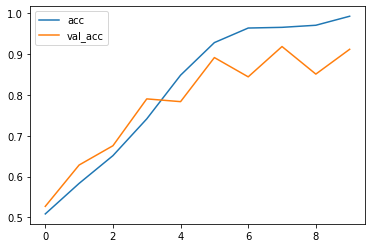

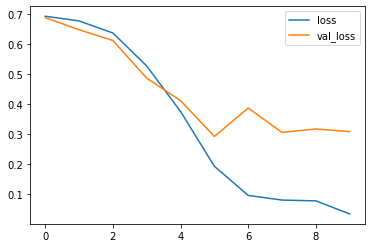

<Figure size 432x288 with 0 Axes>

In [228]:
plt.plot(stack_lstm.history['accuracy'], label='acc')
plt.plot(stack_lstm.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")


# In[25]:


plt.plot(stack_lstm.history['loss'], label='loss')
plt.plot(stack_lstm.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

In [79]:
test_eval(Stacked_LSTM, X_test, y_test, algo='Satcked-LSTM')

C:\Users\Sudhakor Das\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


12/12 [==============================] - 1s 23ms/step
Confusion Matrix
[[ 79  96]
 [ 21 167]] 

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.45      0.57       175
           1       0.63      0.89      0.74       188

    accuracy                           0.68       363
   macro avg       0.71      0.67      0.66       363
weighted avg       0.71      0.68      0.66       363
 

Accuracy Score
0.6776859504132231


# Stacked_BiLSTM

In [88]:
maxlen = 20
bilstm_model = Sequential() 
bilstm_model.add(Embedding(vocab_size ,W2V_SIZE, weights=[embedding_matrix] , input_length = maxlen, name = "embedding", trainable = False))

#bilstm_model.add(Embedding(vocab_size, embedding_vector_length, input_length=maxlen))
bilstm_model.add(Bidirectional(LSTM(50, return_sequences=True)))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Bidirectional(LSTM(100, return_sequences=True)))
#bilstm_model.add(Dropout(0.2))
bilstm_model.add(Bidirectional(LSTM(150)))


#bilstm_model.add(Dense(64, activation='relu'))
bilstm_model.add(Dropout(0.1))
bilstm_model.add(Dense(1, activation='sigmoid'))

 
bilstm_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(bilstm_model.summary()) 

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           463900    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 20, 100)           60400     
_________________________________________________________________
dropout_24 (Dropout)         (None, 20, 100)           0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 20, 200)           160800    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 300)               421200    
_________________________________________________________________
dropout_25 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)               

In [89]:
stack_bilstm = bilstm_model.fit(X_train,y_train,validation_split=0.2, epochs=20)

Epoch 1/20
19/19 [==============================] - 31s 493ms/step - loss: 0.6735 - accuracy: 0.5408 - val_loss: 0.6336 - val_accuracy: 0.6351
Epoch 2/20
19/19 [==============================] - 4s 206ms/step - loss: 0.6509 - accuracy: 0.6449 - val_loss: 0.6183 - val_accuracy: 0.6486
Epoch 3/20
19/19 [==============================] - 6s 306ms/step - loss: 0.5984 - accuracy: 0.6668 - val_loss: 0.6412 - val_accuracy: 0.6689
Epoch 4/20
19/19 [==============================] - 6s 307ms/step - loss: 0.6288 - accuracy: 0.6375 - val_loss: 0.5982 - val_accuracy: 0.6622
Epoch 5/20
19/19 [==============================] - 6s 317ms/step - loss: 0.6002 - accuracy: 0.6870 - val_loss: 0.6323 - val_accuracy: 0.6419
Epoch 6/20
19/19 [==============================] - 6s 311ms/step - loss: 0.6064 - accuracy: 0.6584 - val_loss: 0.5925 - val_accuracy: 0.6824
Epoch 7/20
19/19 [==============================] - 6s 309ms/step - loss: 0.6181 - accuracy: 0.6365 - val_loss: 0.5972 - val_accuracy: 0.6757
Epoch

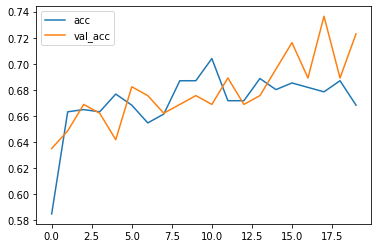

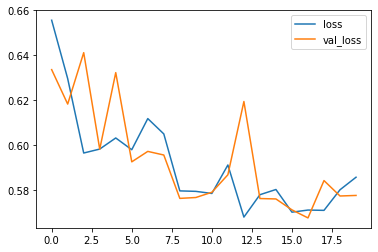

<Figure size 432x288 with 0 Axes>

In [90]:
plt.plot(stack_bilstm.history['accuracy'], label='acc')
plt.plot(stack_bilstm.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")


# In[25]:


plt.plot(stack_bilstm.history['loss'], label='loss')
plt.plot(stack_bilstm.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

In [91]:
test_eval(bilstm_model, X_test, y_test, algo='Satcked-Bilstm')

C:\Users\Sudhakor Das\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


12/12 [==============================] - 5s 70ms/step
Confusion Matrix
[[123  52]
 [ 72 116]] 

Classification Report
              precision    recall  f1-score   support

           0       0.63      0.70      0.66       175
           1       0.69      0.62      0.65       188

    accuracy                           0.66       363
   macro avg       0.66      0.66      0.66       363
weighted avg       0.66      0.66      0.66       363
 

Accuracy Score
0.6584022038567493


In [160]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    print(tw)
    tw = pad_sequences(tw,maxlen=15)
    print(tw)

    pred = bi_model.predict(tw)
    print(pred)
    #prediction = int(model.predict(tw).round().item())
    #print(prediction)
    if pred < .5:
        sen = 0
    else:
        sen = 1
    print("Predicted label: ", comment_label[1][sen])


In [168]:
text = 'বএতল্লাই তো এক নম্বর আইগেয়ু বালি'
predict_sentiment(text)

[[37, 99, 4751]]
[[   0    0    0    0    0    0    0    0    0    0    0    0   37   99
  4751]]
[[0.99962115]]
Predicted label:  No


# Stacked_GRU

In [100]:

maxlen = 20
gru_model = Sequential() 

gru_model.add(Embedding(vocab_size ,W2V_SIZE, weights=[embedding_matrix] , input_length = maxlen, name = "embedding", trainable = False))

#gru_model.add(Embedding(vocab_size, embedding_vector_length, input_length=maxlen))

gru_model.add(GRU(50, return_sequences=True, activation='relu'))
gru_model.add(Dropout(0.2))
# Second GRU layer
gru_model.add(GRU(80, return_sequences=True, activation='relu'))
gru_model.add(Dropout(0.2))
#Third GRU layer
gru_model.add(GRU(100, activation='relu'))
gru_model.add(Dropout(0.2))
# Fourth GRU layer
#gru_model.add(GRU(units=50, activation='relu'))
#gru_model.add(Dropout(0.2))
# The output layer
gru_model.add(Dense(1, activation='sigmoid'))

 
gru_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(gru_model.summary()) 

stack_gru = gru_model.fit(X_train,y_train,validation_split=0.2, epochs=30)

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           463900    
_________________________________________________________________
gru_18 (GRU)                 (None, 20, 50)            22800     
_________________________________________________________________
dropout_44 (Dropout)         (None, 20, 50)            0         
_________________________________________________________________
gru_19 (GRU)                 (None, 20, 80)            31680     
_________________________________________________________________
dropout_45 (Dropout)         (None, 20, 80)            0         
_________________________________________________________________
gru_20 (GRU)                 (None, 100)               54600     
_________________________________________________________________
dropout_46 (Dropout)         (None, 100)             

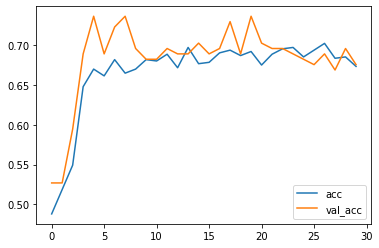

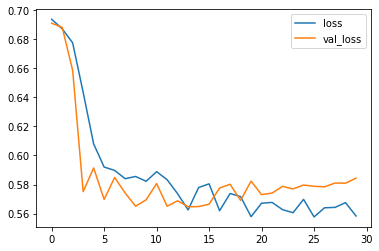

<Figure size 432x288 with 0 Axes>

In [101]:
plt.plot(stack_gru.history['accuracy'], label='acc')
plt.plot(stack_gru.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")


# In[25]:


plt.plot(stack_gru.history['loss'], label='loss')
plt.plot(stack_gru.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

In [102]:
test_eval(gru_model, X_test, y_test, algo='Satcked-GRU')

C:\Users\Sudhakor Das\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


12/12 [==============================] - 1s 31ms/step
Confusion Matrix
[[ 95  80]
 [ 36 152]] 

Classification Report
              precision    recall  f1-score   support

           0       0.73      0.54      0.62       175
           1       0.66      0.81      0.72       188

    accuracy                           0.68       363
   macro avg       0.69      0.68      0.67       363
weighted avg       0.69      0.68      0.67       363
 

Accuracy Score
0.6804407713498623


In [192]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    print(tw)
    tw = pad_sequences(tw,maxlen=15)
    print(tw)

    pred = gru_model.predict(tw)
    print(pred)
    #prediction = int(model.predict(tw).round().item())
    #print(prediction)
    if pred < .5:
        sen = 0
    else:
        sen = 1
    print("Predicted label: ", comment_label[1][sen])


In [194]:
text = 'সানাই অলদি মাগী'
predict_sentiment(text)

[[63, 603, 787]]
[[  0   0   0   0   0   0   0   0   0   0   0   0  63 603 787]]
[[0.4995999]]
Predicted label:  Yes


# Stacked_BiGRU

In [103]:
maxlen = 20
bigru_model = Sequential() 

bigru_model.add(Embedding(vocab_size ,W2V_SIZE, weights=[embedding_matrix] , input_length = maxlen, name = "embedding", trainable = False))

#bigru_model.add(Embedding(vocab_size, embedding_vector_length, input_length=maxlen))

bigru_model.add(Bidirectional(GRU(32, return_sequences=True)))
bigru_model.add(Dropout(0.2))

bigru_model.add(Bidirectional(GRU(64, return_sequences=True)))
bigru_model.add(Dropout(0.2))

bigru_model.add(Bidirectional(GRU(64)))
bigru_model.add(Dropout(0.2))

bigru_model.add(Dense(64, activation='relu'))
bigru_model.add(Dropout(0.1))
bigru_model.add(Dense(1, activation='sigmoid'))

 
bigru_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(bigru_model.summary()) 


stack_bigru = bigru_model.fit(X_train,y_train,validation_split=0.2, epochs=20)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           463900    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 20, 64)            25728     
_________________________________________________________________
dropout_47 (Dropout)         (None, 20, 64)            0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 20, 128)           49920     
_________________________________________________________________
dropout_48 (Dropout)         (None, 20, 128)           0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 128)               74496     
_________________________________________________________________
dropout_49 (Dropout)         (None, 128)             

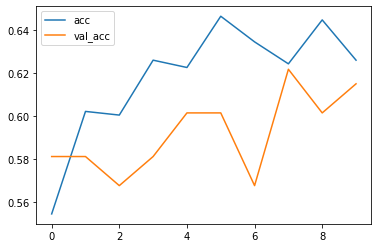

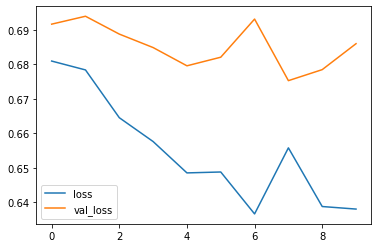

<Figure size 432x288 with 0 Axes>

In [170]:
plt.plot(stack_bigru.history['accuracy'], label='acc')
plt.plot(stack_bigru.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")


# In[25]:


plt.plot(stack_bigru.history['loss'], label='loss')
plt.plot(stack_bigru.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

In [105]:
test_eval(bigru_model, X_test, y_test, algo='Stacked-biGRU')

C:\Users\Sudhakor Das\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


12/12 [==============================] - 5s 30ms/step
Confusion Matrix
[[ 87  88]
 [ 29 159]] 

Classification Report
              precision    recall  f1-score   support

           0       0.75      0.50      0.60       175
           1       0.64      0.85      0.73       188

    accuracy                           0.68       363
   macro avg       0.70      0.67      0.66       363
weighted avg       0.69      0.68      0.67       363
 

Accuracy Score
0.6776859504132231


In [184]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    print(tw)
    tw = pad_sequences(tw,maxlen=15)
    print(tw)

    pred = gru_model.predict(tw)
    print(pred)
    #prediction = int(model.predict(tw).round().item())
    #print(prediction)
    if pred < .4:
        sen = 0
    else:
        sen = 1
    print("Predicted label: ", comment_label[1][sen])


In [191]:
text = ' মাগি'
predict_sentiment(text)

[[4]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 4]]
[[0.4994589]]
Predicted label:  No


In [106]:
Model

['SimpleRNN', 'Satcked-LSTM', 'Satcked-Bilstm', 'Satcked-GRU', 'Stacked-biGRU']

# Text Classification using CNN

In [113]:
cnn_model = Sequential() 

cnn_model.add(Embedding(vocab_size ,W2V_SIZE, weights=[embedding_matrix] , input_length = maxlen, name = "embedding", trainable = False))
#model.add(Embedding(vocab_size, embedding_vector_length, input_length=16, name = "embedding") )
#model.add(SpatialDropout1D(0.25))
cnn_model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5 ,return_sequences = True))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv1D(50, 3, activation = 'relu'))
#cnn_model.add(GlobalMaxPooling1D())
#cnn_model.add(MaxPooling1D(pool_size=2))

cnn_model.add(Conv1D(80, 3, activation = 'relu'))
cnn_model.add(MaxPooling1D(pool_size=2))

cnn_model.add(Conv1D(128, 3, activation = 'relu'))
#cnn_model.add(MaxPooling1D(pool_size=2))

cnn_model.add(Dropout(.2))
cnn_model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
cnn_model.add(Dropout(0.2))


cnn_model.add(Dense(1, activation='sigmoid')) 

cnn_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(cnn_model.summary()) 

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           463900    
_________________________________________________________________
lstm_33 (LSTM)               (None, 20, 50)            30200     
_________________________________________________________________
dropout_60 (Dropout)         (None, 20, 50)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 18, 50)            7550      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 16, 80)            12080     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 8, 80)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 6, 128)          

In [115]:
cnn = cnn_model.fit(X_train,y_train,validation_split=0.2, epochs=20)

Epoch 1/20
19/19 [==============================] - 2s 82ms/step - loss: 0.5825 - accuracy: 0.6871 - val_loss: 0.5617 - val_accuracy: 0.6689
Epoch 2/20
19/19 [==============================] - 1s 71ms/step - loss: 0.5851 - accuracy: 0.6684 - val_loss: 0.5767 - val_accuracy: 0.6554
Epoch 3/20
19/19 [==============================] - 1s 73ms/step - loss: 0.5973 - accuracy: 0.6837 - val_loss: 0.5689 - val_accuracy: 0.6757
Epoch 4/20
19/19 [==============================] - 1s 66ms/step - loss: 0.5792 - accuracy: 0.6667 - val_loss: 0.5581 - val_accuracy: 0.7095
Epoch 5/20
19/19 [==============================] - 1s 70ms/step - loss: 0.5893 - accuracy: 0.6701 - val_loss: 0.5744 - val_accuracy: 0.6959
Epoch 6/20
19/19 [==============================] - 1s 69ms/step - loss: 0.5964 - accuracy: 0.6701 - val_loss: 0.5688 - val_accuracy: 0.7027
Epoch 7/20
19/19 [==============================] - 1s 70ms/step - loss: 0.5807 - accuracy: 0.6786 - val_loss: 0.5631 - val_accuracy: 0.7162
Epoch 8/20
19

In [116]:
test_eval(cnn_model, X_test, y_test, algo='CNN')

C:\Users\Sudhakor Das\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


12/12 [==============================] - 2s 18ms/step
Confusion Matrix
[[ 94  81]
 [ 29 159]] 

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.54      0.63       175
           1       0.66      0.85      0.74       188

    accuracy                           0.70       363
   macro avg       0.71      0.69      0.69       363
weighted avg       0.71      0.70      0.69       363
 

Accuracy Score
0.696969696969697


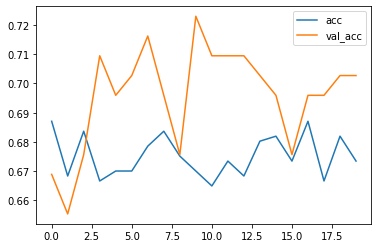

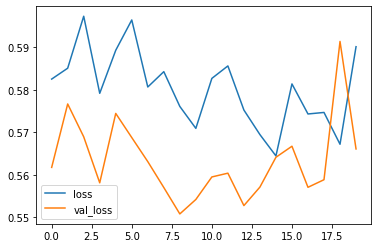

<Figure size 432x288 with 0 Axes>

In [117]:
plt.plot(cnn.history['accuracy'], label='acc')
plt.plot(cnn.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")


# In[25]:


plt.plot(cnn.history['loss'], label='loss')
plt.plot(cnn.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

# LSTM + GRU

In [121]:
lstm_gru = Sequential() 

lstm_gru.add(Embedding(vocab_size ,W2V_SIZE, weights=[embedding_matrix] , input_length = maxlen, name = "embedding", trainable = False))
#model.add(Embedding(vocab_size, embedding_vector_length, input_length=16, name = "embedding") )
lstm_gru.add(SpatialDropout1D(0.25))
lstm_gru.add(LSTM(50, dropout=0.5, return_sequences=True, activation='relu' ))
lstm_gru.add(Dropout(0.2))
lstm_gru.add(LSTM(100, dropout=0.5, return_sequences=True, activation='relu' ))
lstm_gru.add(Dropout(0.2))
lstm_gru.add(LSTM(150, dropout=0.5, return_sequences=True, activation='relu' ))
lstm_gru.add(Dropout(0.2))

lstm_gru.add(GRU(32, return_sequences=True, activation='relu'))
lstm_gru.add(Dropout(0.2))
lstm_gru.add(GRU(64, return_sequences=True, activation='relu'))
lstm_gru.add(Dropout(0.2))
lstm_gru.add(GRU(128, activation='relu'))
lstm_gru.add(Dropout(0.2))

lstm_gru.add(Dense(1, activation='sigmoid')) 
lstm_gru.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(lstm_gru.summary()) 

lstmgru = lstm_gru.fit(X_train,y_train,validation_split=0.2, epochs=20)

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           463900    
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 20, 100)           0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 20, 50)            30200     
_________________________________________________________________
dropout_75 (Dropout)         (None, 20, 50)            0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 20, 100)           60400     
_________________________________________________________________
dropout_76 (Dropout)         (None, 20, 100)           0         
_________________________________________________________________
lstm_43 (LSTM)               (None, 20, 150)         

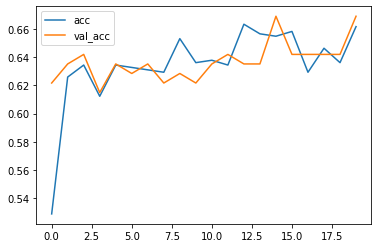

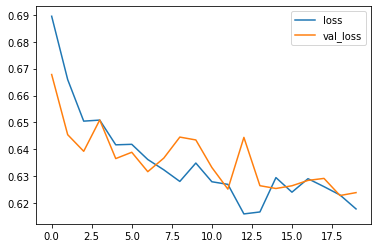

<Figure size 432x288 with 0 Axes>

In [122]:
plt.plot(lstmgru.history['accuracy'], label='acc')
plt.plot(lstmgru.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")


# In[25]:


plt.plot(lstmgru.history['loss'], label='loss')
plt.plot(lstmgru.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

In [123]:
test_eval(lstm_gru, X_test, y_test, algo='LSTM+GRU')

C:\Users\Sudhakor Das\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


12/12 [==============================] - 3s 68ms/step
Confusion Matrix
[[ 85  90]
 [ 48 140]] 

Classification Report
              precision    recall  f1-score   support

           0       0.64      0.49      0.55       175
           1       0.61      0.74      0.67       188

    accuracy                           0.62       363
   macro avg       0.62      0.62      0.61       363
weighted avg       0.62      0.62      0.61       363
 

Accuracy Score
0.6198347107438017


# LSTM+CNN

In [125]:

lstm_cnn = Sequential() 
lstm_cnn.add(Embedding(vocab_size ,W2V_SIZE, weights=[embedding_matrix] , input_length = maxlen, name = "embedding", trainable = False))
#model.add(Embedding(vocab_size, embedding_vector_length, input_length=16, name = "embedding") )
lstm_cnn.add(SpatialDropout1D(0.25))
lstm_cnn.add(LSTM(50, dropout=0.5, return_sequences=True, activation='relu' ))
lstm_cnn.add(Dropout(0.2))
lstm_cnn.add(LSTM(100, dropout=0.5, return_sequences=True, activation='relu' ))
lstm_cnn.add(Dropout(0.2))
lstm_cnn.add(LSTM(150, dropout=0.5, return_sequences=True, activation='relu' ))
lstm_cnn.add(Dropout(0.2))

lstm_cnn.add(Conv1D(40, 3, activation = 'relu'))
#model.add(GlobalMaxPooling1D())
lstm_cnn.add(Dropout(.2))
lstm_cnn.add(Conv1D(120, 3, activation = 'relu'))
#model.add(GlobalMaxPooling1D())
lstm_cnn.add(Dropout(.2))
lstm_cnn.add(Conv1D(170, 3, activation = 'relu'))
#model.add(GlobalMaxPooling1D())
lstm_cnn.add(Dropout(.2))
lstm_cnn.add(GlobalMaxPooling1D())

lstm_cnn.add(Dense(1, activation='sigmoid')) 
lstm_cnn.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(lstm_cnn.summary()) 

lstmcnn = lstm_cnn.fit(X_train,y_train,validation_split=0.2, epochs=20)

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           463900    
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 20, 100)           0         
_________________________________________________________________
lstm_47 (LSTM)               (None, 20, 50)            30200     
_________________________________________________________________
dropout_87 (Dropout)         (None, 20, 50)            0         
_________________________________________________________________
lstm_48 (LSTM)               (None, 20, 100)           60400     
_________________________________________________________________
dropout_88 (Dropout)         (None, 20, 100)           0         
_________________________________________________________________
lstm_49 (LSTM)               (None, 20, 150)         

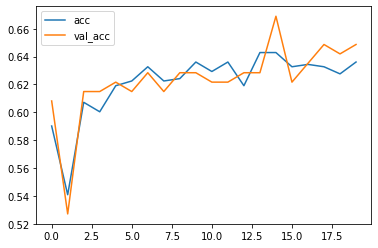

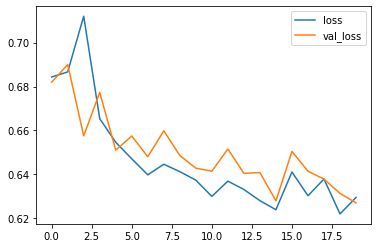

<Figure size 432x288 with 0 Axes>

In [126]:
plt.plot(lstmcnn.history['accuracy'], label='acc')
plt.plot(lstmcnn.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")


# In[25]:


plt.plot(lstmcnn.history['loss'], label='loss')
plt.plot(lstmcnn.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

In [127]:
test_eval(lstm_cnn, X_test, y_test, algo='LSTM+CNN')

C:\Users\Sudhakor Das\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


12/12 [==============================] - 2s 48ms/step
Confusion Matrix
[[ 78  97]
 [ 46 142]] 

Classification Report
              precision    recall  f1-score   support

           0       0.63      0.45      0.52       175
           1       0.59      0.76      0.67       188

    accuracy                           0.61       363
   macro avg       0.61      0.60      0.59       363
weighted avg       0.61      0.61      0.60       363
 

Accuracy Score
0.6060606060606061


# GRU + CNN

In [128]:
gru_cnn = Sequential() 
gru_cnn.add(Embedding(vocab_size ,W2V_SIZE, weights=[embedding_matrix] , input_length = maxlen, name = "embedding", trainable = False))
#model.add(Embedding(vocab_size, embedding_vector_length, input_length=16, name = "embedding") )
gru_cnn.add(SpatialDropout1D(0.25))

gru_cnn.add(GRU(40, return_sequences=True, activation='relu'))
gru_cnn.add(Dropout(0.2))
gru_cnn.add(GRU(80, return_sequences=True, activation='relu'))
gru_cnn.add(Dropout(0.2))
gru_cnn.add(GRU(100, activation='relu', return_sequences = True))
gru_cnn.add(Dropout(0.2))

gru_cnn.add(Conv1D(50, 3, activation = 'relu'))
#model.add(GlobalMaxPooling1D())
gru_cnn.add(Dropout(.2))
gru_cnn.add(Conv1D(80, 3, activation = 'relu'))
#model.add(GlobalMaxPooling1D())
gru_cnn.add(Dropout(.2))
gru_cnn.add(Conv1D(150, 3, activation = 'relu'))
#model.add(GlobalMaxPooling1D())
gru_cnn.add(Dropout(.2))
gru_cnn.add(GlobalMaxPooling1D())


gru_cnn.add(Dense(1, activation='sigmoid')) 
gru_cnn.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(gru_cnn.summary()) 

grucnn = gru_cnn.fit(X_train,y_train,validation_split=0.2, epochs=30)

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           463900    
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 20, 100)           0         
_________________________________________________________________
gru_33 (GRU)                 (None, 20, 40)            17040     
_________________________________________________________________
dropout_93 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
gru_34 (GRU)                 (None, 20, 80)            29280     
_________________________________________________________________
dropout_94 (Dropout)         (None, 20, 80)            0         
_________________________________________________________________
gru_35 (GRU)                 (None, 20, 100)         

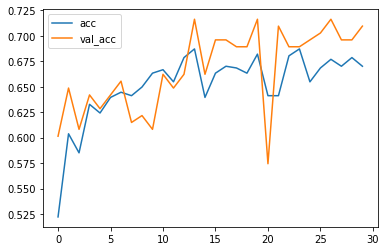

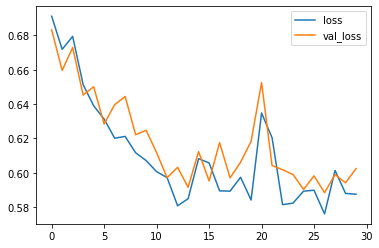

<Figure size 432x288 with 0 Axes>

In [129]:
plt.plot(grucnn.history['accuracy'], label='acc')
plt.plot(grucnn.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")


# In[25]:


plt.plot(grucnn.history['loss'], label='loss')
plt.plot(grucnn.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

In [130]:
test_eval(gru_cnn, X_test, y_test, algo='GRU+CNN')

C:\Users\Sudhakor Das\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


12/12 [==============================] - 2s 44ms/step
Confusion Matrix
[[114  61]
 [ 69 119]] 

Classification Report
              precision    recall  f1-score   support

           0       0.62      0.65      0.64       175
           1       0.66      0.63      0.65       188

    accuracy                           0.64       363
   macro avg       0.64      0.64      0.64       363
weighted avg       0.64      0.64      0.64       363
 

Accuracy Score
0.6418732782369146


# LSTM + GRU + CNN

In [132]:
lgc = Sequential() 
lgc.add(Embedding(vocab_size ,W2V_SIZE, weights=[embedding_matrix] , input_length = maxlen, name = "embedding", trainable = False))
#model.add(Embedding(vocab_size, embedding_vector_length, input_length=16, name = "embedding") )
lgc.add(SpatialDropout1D(0.25))
lgc.add(LSTM(50, dropout=0.5, return_sequences=True, activation='relu' ))
lgc.add(Dropout(0.2))
lgc.add(LSTM(100, dropout=0.5, return_sequences=True, activation='relu' ))
lgc.add(Dropout(0.2))
lgc.add(LSTM(150, dropout=0.5, return_sequences=True, activation='relu' ))
lgc.add(Dropout(0.2))

lgc.add(GRU(50, return_sequences=True, activation='relu'))
lgc.add(Dropout(0.2))
lgc.add(GRU(100, return_sequences=True, activation='relu'))
lgc.add(Dropout(0.2))
lgc.add(GRU(150, activation='relu', return_sequences = True))
lgc.add(Dropout(0.2))

lgc.add(Conv1D(50, 3, activation = 'relu'))
#model.add(GlobalMaxPooling1D())
lgc.add(Dropout(.2))
lgc.add(Conv1D(90, 3, activation = 'relu'))
#model.add(GlobalMaxPooling1D())
lgc.add(Dropout(.2))
lgc.add(Conv1D(150, 3, activation = 'relu'))
#model.add(GlobalMaxPooling1D())
lgc.add(Dropout(.2))
lgc.add(GlobalMaxPooling1D())

lgc.add(Dense(1, activation='sigmoid')) 
lgc.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(lgc.summary()) 

Lgc = lgc.fit(X_train,y_train,validation_split=0.2, epochs=30)

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           463900    
_________________________________________________________________
spatial_dropout1d_11 (Spatia (None, 20, 100)           0         
_________________________________________________________________
lstm_53 (LSTM)               (None, 20, 50)            30200     
_________________________________________________________________
dropout_108 (Dropout)        (None, 20, 50)            0         
_________________________________________________________________
lstm_54 (LSTM)               (None, 20, 100)           60400     
_________________________________________________________________
dropout_109 (Dropout)        (None, 20, 100)           0         
_________________________________________________________________
lstm_55 (LSTM)               (None, 20, 150)         

In [133]:
test_eval(lgc, X_test, y_test, algo='LSTM+GRU+CNN')

C:\Users\Sudhakor Das\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


12/12 [==============================] - 3s 77ms/step
Confusion Matrix
[[ 77  98]
 [ 45 143]] 

Classification Report
              precision    recall  f1-score   support

           0       0.63      0.44      0.52       175
           1       0.59      0.76      0.67       188

    accuracy                           0.61       363
   macro avg       0.61      0.60      0.59       363
weighted avg       0.61      0.61      0.60       363
 

Accuracy Score
0.6060606060606061


In [134]:
Model

['SimpleRNN',
 'Satcked-LSTM',
 'Satcked-Bilstm',
 'Satcked-GRU',
 'Stacked-biGRU',
 'CNN',
 'LSTM+GRU',
 'LSTM+CNN',
 'GRU+CNN',
 'LSTM+GRU+CNN']

In [135]:
clf_eval_df = pd.DataFrame({'Model':Model,
                            'Accuracy':Accuracy,
                            'Precision':precision,
                            'Recall':recall,
                            'F1-score':F1score,
                            })

In [136]:
clf_eval_df

,Model,Accuracy,Precision,Recall,F1-score
0,SimpleRNN,0.90,0.94,0.87,0.90
1,Satcked-LSTM,0.68,0.63,0.89,0.74
2,Satcked-Bilstm,0.66,0.69,0.62,0.65
3,Satcked-GRU,0.68,0.66,0.81,0.72
4,Stacked-biGRU,0.68,0.64,0.85,0.73
5,CNN,0.70,0.66,0.85,0.74
6,LSTM+GRU,0.62,0.61,0.74,0.67
7,LSTM+CNN,0.61,0.59,0.76,0.67
8,GRU+CNN,0.64,0.66,0.63,0.65
9,LSTM+GRU+CNN,0.61,0.59,0.76,0.67


In [137]:
clf_eval_df.to_csv('Fast-text.csv')

In [ ]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    print(tw)
    tw = pad_sequences(tw,maxlen=16)
    #pred = model.predict(tw).item()
    #print(pred)
    prediction = int(model.predict(tw).round().item())
    print(prediction)
    print("Predicted label: ", sentiment_label[1][prediction])


In [ ]:
test_sentence1 = "খানকির পোলা রোহিঙ্গারা বাংলাদেশে ঢুকলে কি তোর কোন সমস্যাে"
predict_sentiment(test_sentence1)

In [ ]:
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=10)

In [ ]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")


# In[25]:


plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")


In [ ]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=16)
    pred = model.predict(tw).item()
    print(pred)
    prediction = int(model.predict(tw).round().item())
    print(prediction)
    print("Predicted label: ", sentiment_label[1][prediction])


In [ ]:
test_sentence1 = "খুব কষ্ট লাগলো রিকশাওয়ালা চাচার আর্তনাদ দেখে"
predict_sentiment(test_sentence1)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=unique_vocab+1, output_dim=embedding_dim, input_length=max_len,
                    weights=[embedding_matrix],trainable=False))



model.add(SpatialDropout1D((0.25)))

model.add(Conv1D(filters=300, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2,stride=1))
model.add(BatchNormalization()) 
model.add(SpatialDropout1D((0.5)))

model.add(Conv1D(filters=300, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2,stride=1))
model.add(BatchNormalization()) 
model.add(SpatialDropout1D((0.5)))



model.add(Conv1D(300,4,padding='same',kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model.add(advanced_activations.LeakyReLU(alpha=0.3))
model.add(MaxPooling1D(pool_size=2,stride=1))
model.add(BatchNormalization()) 
model.add(SpatialDropout1D((0.5)))

model.add(Conv1D(300,4,padding='same',kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model.add(advanced_activations.LeakyReLU(alpha=0.3))
model.add(MaxPooling1D(pool_size=2,stride=1))
model.add(BatchNormalization()) 
model.add(SpatialDropout1D((0.5)))



model.add(Bidirectional(CuDNNLSTM(256,kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01),return_sequences=False)))